# Create Training Set with Simulated Pulsars

Based on Python 3.
Required software:
1. sigpyproc
2. sigproc
3. scipy
4. pandas
5. numpy
6. SKA-TestVectorGenerationPipeline v2.0 from https://github.com/scienceguyrob/SKA-TestVectorGenerationPipeline
7. Tempo 2

We take a real observation and create an empty, downsampled version of this file. Into this file we inject the simulated pulsars.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from sigpyproc.Readers import FilReader as reader
import scipy.signal
import scipy
import pandas as pd
current_path = os.getcwd()
print(current_path)

/data/lkuenkel/neural_nets/DeepPulsarNet/deeppulsarnet/notebooks


In [2]:
# Folder where data will be saved
output_path = '/data/lkuenkel/data/pipeline_test/'
!mkdir {output_path}
# Define input file, if not filterbank file yet will be converted later
input_example_file = '/data/lkuenkel/data/PMPS/1997AUGT/raw/PM0001_00111.sf'
# Name for converted filterbank file
input_fil_file = f'{output_path}input.fil'
# Name of downsampled filterbank file
downsampled_input = f'{output_path}example_downsampled.fil'
# Name of empty filterbank file, this file be used to inject the simulated pulsars
empty_file = f'{output_path}zero.fil'

mkdir: cannot create directory ‘/data/lkuenkel/data/pipeline_test/’: File exists


## Create Downsampled File
This step creates a downsampled version of one filterbank. If the file is in sigproc filterbank format and you do not want to downsample, then skip this step and set *downsampled_input* to the input file.

In [3]:
# Parameters for downsampling
t_downsample = 10
f_downsample = 2
nbits = 8

tstart = 50000

In [111]:
# No conversion to filterbank needed if data is already sigproc filterbank
# filterbank and decimate are sigproc tools
!filterbank {input_example_file} > {input_fil_file}
!decimate -c {f_downsample} -t {t_downsample} -n {nbits} {input_fil_file} > {downsampled_input}

hdr
Native fch1=1516.500000, foff=-3.000000
hdr
Native fch1=1516.500000, foff=-3.000000


## Create Empty File

In [5]:
fil = reader(downsampled_input)
channel_number = fil.header['nchans']
mask = np.zeros(channel_number)
f_range = (fil.header['fch1'], fil.header['fch1']+fil.header['foff']*fil.header['nchans'])
fil.header['tstart'] = tstart
fil.applyChannelMask(mask, empty_file)


Filterbank reading plan:
------------------------
Called on file:        /data/lkuenkel/data/pipeline_test/example_downsampled.fil
Called by:             applyChannelMask
Number of samps:       840089
Number of reads:       1640
Nsamps per read:       512
Nsamps of final read:  409
Nsamps to skip back:   0

Execution time: 1.363476 seconds     



'/data/lkuenkel/data/pipeline_test/zero.fil'

In [6]:
fil.header

{'source_name': 'G4783503',
 'telescope_id': 4,
 'machine_id': 4294967295,
 'src_raj': 134652.518,
 'src_dej': -613331.02,
 'az_start': 0.0,
 'za_start': 0.0,
 'data_type': 1,
 'fch1': 1516.5,
 'foff': -6.0,
 'nchans': 48,
 'nbits': 8,
 'tstart': 50000,
 'tsamp': 0.0025,
 'nifs': 1,
 'barycentric': 0,
 'hdrlen': 315,
 'filelen': 40324615,
 'nbytes': 40324300,
 'nsamples': 840089,
 'filename': '/data/lkuenkel/data/pipeline_test/example_downsampled.fil',
 'basename': '/data/lkuenkel/data/pipeline_test/example_downsampled',
 'extension': '.fil',
 'bandwidth': 288.0,
 'ftop': 1519.5,
 'fbottom': 1231.5,
 'fcenter': 1375.5,
 'tobs': 2100.2225,
 'ra': '13:46:52.5180',
 'dec': '-61:33:31.0200',
 'ra_rad': 3.6079241221039666,
 'dec_rad': -1.07440054380639,
 'ra_deg': 206.71882499999995,
 'dec_deg': -61.55861666666666,
 'obs_date': '09/10/1995',
 'obs_time': '00:00:00.00000',
 'dtype': '<u1'}

## Create Training Data Set

In [7]:
# Set the paths
pipeline_path = '/data/lkuenkel/newstack/SKA-TestVectorGenerationPipeline'

In [29]:
# Parameters
# number of predictor files
n_files = 20
#snr_para = '--snr uniform --snrparams 70:0'
#dm_para = '--dm uniform --dmparams 20:680'
#p0_para = '--p0 uniform --p0params 0.1:1.4'
dm_distribution = np.random.uniform(20, 700, n_files)
p0_distribution = np.random.uniform(0.1, 1, n_files)

set_name = 'training_set_1'

In [30]:
# Create Folders
set_path = f'{output_path}{set_name}'
pars_path = f'{output_path}{set_name}/pars'
preds_path = f'{output_path}{set_name}/pred'
cmd_path = f'{output_path}{set_name}/cmd'
data_path = f'{output_path}{set_name}/data'
fake_prof_path = f'{output_path}{set_name}/prof_fake'

In [31]:
#!mkdir {data_path}

In [32]:
# Reset Folders 
!rm -r {set_path}
!mkdir {set_path}
!mkdir {pars_path}
!mkdir {preds_path}
!mkdir {cmd_path}
!mkdir {data_path}
!mkdir {fake_prof_path}

1. Creates Pars
2. Create Preds
3. Create command list
4. Execute command list

The Python 3 compatible version of SKA-TestVectorGenerationPipeline only supportes creating multiple pulsars with different periods at the same DM. FOr multiple DMs we have to run it multiple times.

In [33]:
%%capture
for (period, dm) in zip(p0_distribution, dm_distribution):
    command_string = f'-m {dm:.2f} -d {pars_path} -p {period:.4f} -a 0'
    %run {pipeline_path}/code/pulsar_injection_pipeline/beta/main/src/CreateFakeParFiles.py {command_string}

In [34]:
chunks = n_files // 1000
f_high = int(np.ceil(max(f_range)))
f_low = int(np.floor(min(f_range)))
command_string = f'--tel PARKES  -p {pars_path} -d {preds_path} -s 2000 --f1 {f_low} --f2 {f_high} --mjd1 {tstart} --mjd2 {tstart+0.2}'
print(command_string)
for chunk in range(chunks+1):
    %run {pipeline_path}/code/pulsar_injection_pipeline/beta/main/src/GeneratePredictorFiles.py {command_string}

--tel PARKES  -p /data/lkuenkel/data/pipeline_test/training_set_1/pars -d /data/lkuenkel/data/pipeline_test/training_set_1/pred -s 2000 --f1 1228 --f2 1517 --mjd1 50000 --mjd2 50000.2

    ***************************************************************************************
    |                                                                                     |
    |                    Generate Tempo 2 predictor Files Version 2.0                     |
    |                                                                                     |
    ***************************************************************************************
    | Description:                                                                        |
    |                                                                                     |
    | Generates Tempo2 predictor files, for all PAR files in a user specified directory.  |
    | The predictor files are stored in a user defined output directory. This s

In [35]:
snr_value = 70

In [36]:
#%%capture
#asc_paths = '/data/lkuenkel/software/SKA_rob/ASC/good/'
#asc_paths = f"{pipeline_path}/resources/ASC/all_asc/"
#!unzip {pipeline_path}/resources/ASC/ASC.zip -d {pipeline_path}/resources/ASC/all_asc/

Initially the SKA-TestVectorGenerationPipeline used real pulsar profiles in v1.0. In v2.0 Gaussian profiles are used. I used real pulsar profiles in my work but removed low quality profiles from the data set. Here we use the Gaussian profiles.
v1.0 is more useful in creating a varied training data set but requires Python 2.

In [37]:
profile_number = 5
duty_cycle_distribution = np.random.uniform(0.01, 0.5, profile_number)

In [38]:
%%capture
for duty_cycle in duty_cycle_distribution:
    cycle_string = f"{duty_cycle:.2f}"
    %run {pipeline_path}/code/pulsar_injection_pipeline/beta/main/src/GaussianProfileGen.py -d {cycle_string}
!mv Gaussian*.asc {fake_prof_path}

In [39]:
command_string = f'--asc {fake_prof_path} --pred {preds_path} --out {cmd_path} --noise {empty_file} --batch {n_files} --snr {snr_value} --label {set_name}'
print(command_string)
%run {pipeline_path}/code/pulsar_injection_pipeline/beta/main/src/InjectPulsarCommandCreator.py {command_string} -v

--asc /data/lkuenkel/data/pipeline_test/training_set_1/prof_fake --pred /data/lkuenkel/data/pipeline_test/training_set_1/pred --out /data/lkuenkel/data/pipeline_test/training_set_1/cmd --noise /data/lkuenkel/data/pipeline_test/zero.fil --batch 20 --snr 70 --label training_set_1
"is" with a literal. Did you mean "=="?

    ***************************************************************************************
    |                                                                                     |
    |                     Inject Pulsar Command Creator Version 2.0                       |
    |                                                                                     |
    ***************************************************************************************
    | Description:                                                                        |
    |                                                                                     |
    | Creates a "command" file that 

In [40]:
cmd_files = glob.glob(cmd_path+ '/*.txt')
print(cmd_files)

['/data/lkuenkel/data/pipeline_test/training_set_1/cmd/InjectPulsarCommandFile_20.txt']


In [41]:
for cmd_file in cmd_files:
    %run {pipeline_path}/code/pulsar_injection_pipeline/beta/main/src/InjectPulsarAutomator.py --cmd {cmd_file} --out {data_path}


    ***************************************************************************************
    |                                                                                     |
    |                        Inject Pulsar Automator Version 2.0                          |
    |                                                                                     |
    ***************************************************************************************
    | Description:                                                                        |
    ***************************************************************************************
    |                                                                                     |
    | Automates execution of the inject_pulsar C++ software module, found in Mike Keith's |
    | version of sigproc (https://github.com/SixByNine/sigproc). This script uses the     |
    | Python subprocess library to execute inject_pulsar. The input parameters 

In [85]:
#name_split

['', '20', '740.7', '0.09', '39.15', '0.0', 'Gaussian', '70.0.fil']

In [82]:
created_files = glob.glob(f'{data_path}/*')
print(len(created_files))
# Fixing a naming bug in v2.0
for file in created_files:
    if '\n' in file:
        new_path = file.split('\n')[0]
        !mv "$file" {new_path}
created_files = glob.glob(f'{data_path}/*.fil')
print(len(created_files))

100
100


## Create arrays containing the peak position

In [83]:
%%capture
down_fac = 4
out_folder = f'{set_path}/data_dm_{down_fac}/'
!rm -r {out_folder}
!mkdir {out_folder}
correct_files = []
bad_files = []
approx = []
dedis_names = []
max_dedis_vals = []
tsamp = fil.header['tsamp']
for file in created_files[:]:
    #file = '/data/lkuenkel/data/PMPS/fake/pmps_set1/data/FakePulsar_639_1.291910_396.4_70.0_ASC_J2019+2425_1380.fil'
    name = file.split('/')[-1]
    new_name = '_'.join(name.split('_')[:4])
    name_split = name.split(set_name)[1].split('_')
    full_path = out_folder + new_name+'.npy'
    dm = float(name_split[4])
    period = float(name_split[2])
    approx_dist = 3/4. * period / tsamp /float(down_fac) / 1000
    fil = reader(file)
    #fil_data = fil.readBlock(0,10000)
    #plt.imshow(fil_data, aspect='auto')
    #plt.show()
    dedis = fil.dedisperse(dm, gulp=10000000)
    max_val = np.max(dedis)
    down = dedis.downsample(down_fac)
    down -= np.median(down)
    #down = np.clip(down, 0,10000)
    #down = np.clip(down, 0,np.percentile(down, 99))
    down /= np.max(down)
    peaks, prop = scipy.signal.find_peaks(down, height=0.3, distance=approx_dist)
    #plt.plot(dedis)
    #plt.show()
    #peaks = scipy.signal.find_peaks_cwt(down, [5])
    #print(peaks)
    y_val = np.ones_like(peaks[:3]) 
    #plt.plot(down[:2000])
    #plt.scatter(peaks[:3], y_val)
    #plt.show()
    dummy = np.zeros_like(down).astype(bool)
    dummy[peaks] =1
    acf = scipy.signal.fftconvolve(dummy,dummy[::-1])
    acf /= np.max(acf)
    middle = int(len(acf)/2)
    #plt.plot(acf[middle-2000: middle+2000])
    #plt.show()
    try:
        height = np.max(acf[middle+25: middle+5000]) * 0.3
        acf_peaks, _ = scipy.signal.find_peaks(acf[middle-5: middle+5000], height=height)
        #print(acf_peaks)
        per_calc = (acf_peaks[1] -acf_peaks[0])*down_fac * tsamp
        approx.append((period, per_calc))
        if np.abs(period/1000 - per_calc)/period>0.15:
            bad_files.append(file)
        else:
            correct_files.append(file)
            dedis_names.append(full_path)
            max_dedis_vals.append(max_val)
    except IndexError:
        print(file + 'did not work')
    np.save(full_path, dummy)
    

100


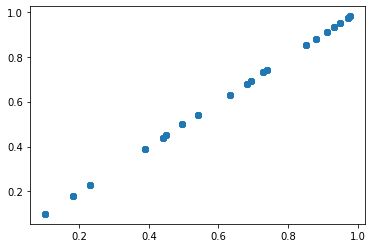

In [110]:
approx_arr = np.asarray(approx)
np.save(f'{set_path}/approx_periods_{down_fac}.npy', approx_arr)
plt.scatter(approx_arr[:,0]/1000, approx_arr[:,1])
print(len(correct_files))

## Create csv_file describing the data

We create two csv files. One containing only the simulated files, one another also containing the same amount of empty lines. When these are loaded during the training process, no pulsars are injected. Label 1 tells us that there is a simulated pulsar. Label 0 means no pulsar.

In [99]:
raw_file_paths = correct_files
raw_file_names = [i.split('/')[-1] for i in raw_file_paths]
raw_file_names_without_set = [i.split(set_name)[1] for i in raw_file_names]
psr_names = ['',]*len(raw_file_paths)
periods = [float(i.split('_')[2])/1000 for i in raw_file_names_without_set]
duty_cycles = [float(i.split('_')[3]) for i in raw_file_names_without_set]
dms = [float(i.split('_')[4]) for i in raw_file_names_without_set]
snrs = [float(i.split('_')[-1].split('.')[0]) for i in raw_file_names_without_set]
print(len(snrs), len(max_dedis_vals))

100 100


In [100]:
data_dict = {'JNAME':psr_names, 'P0':periods, 'DM':dms, 'Label':np.ones_like(psr_names), 'FileName':raw_file_paths, 
             'SNR': snrs, 'MaskName': dedis_names, 'MaxVal': max_dedis_vals, 'DutyCycle': duty_cycles}
df = pd.DataFrame(data=data_dict)

In [101]:
df[:3]

,JNAME,P0,DM,Label,FileName,SNR,MaskName,MaxVal,DutyCycle
0,,0.3890,369.41,1,/data/lkuenkel/data/pipeline_test/training_set...,70.0,/data/lkuenkel/data/pipeline_test/training_set...,48.0,0.22
1,,0.9497,183.72,1,/data/lkuenkel/data/pipeline_test/training_set...,70.0,/data/lkuenkel/data/pipeline_test/training_set...,46.0,0.35
2,,0.9321,123.41,1,/data/lkuenkel/data/pipeline_test/training_set...,70.0,/data/lkuenkel/data/pipeline_test/training_set...,48.0,0.22


In [102]:
dummy_line = {'JNAME':'Noise', 'P0':np.nan, 'DM':np.nan, 'Label':0, 'FileName':'', 
             'SNR': np.nan, 'MaskName': '', 'MaxVal': np.nan, 'DutyCycle': np.nan}

In [103]:
df_noise = df.copy()
for i in range(len(df)):
    df_noise = df_noise.append(dummy_line, ignore_index=True)

In [104]:
df_noise[-3:]

,JNAME,P0,DM,Label,FileName,SNR,MaskName,MaxVal,DutyCycle
197,Noise,NaN,NaN,0,,NaN,,NaN,NaN
198,Noise,NaN,NaN,0,,NaN,,NaN,NaN
199,Noise,NaN,NaN,0,,NaN,,NaN,NaN


In [112]:
df.to_csv(f'../datasets/simset_{set_name}.csv')
df_noise.to_csv(f'../datasets/simset_{set_name}_noise.csv')
print(f"Created: ../datasets/simset_{set_name}.csv")
print(f"Created: ../datasets/simset_{set_name}_noise.csv")
print(f"To use the set use the option: --path simset_{set_name}_noise.csv")

Created: ../datasets/simset_training_set_1.csv
Created: ../datasets/simset_training_set_1_noise.csv
To use the set use the option: --path simset_training_set_1_noise.csv


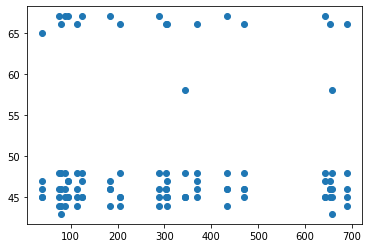

In [106]:
plt.scatter(dms, max_dedis_vals)

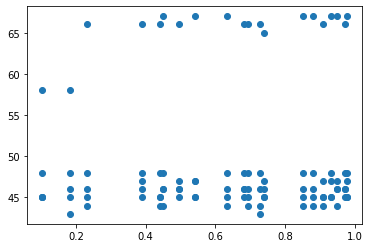

In [107]:
plt.scatter(periods, max_dedis_vals)

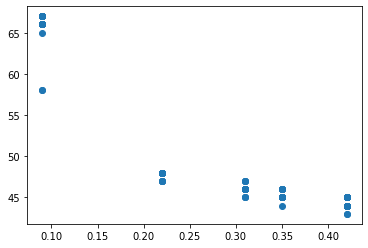

In [108]:
plt.scatter(duty_cycles, max_dedis_vals)